In [1]:
import pandas as pd
import glob
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
## Function to check model assumptions 

def plot_residuals(result):
    
    # Extract residuals and fitted values
    residuals = result.resid
    fitted_values = result.fittedvalues

    # Q-Q plot
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, edgecolor='k')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Residuals vs. Fitted values
    plt.figure(figsize=(8, 6))
    plt.scatter(fitted_values, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.show()

# mAP Score

In [3]:
# nist_result_file = f'results/all.pass.ndcgeval'
# gpt4_result_file = f'results/all.pass.gpt4.ndcgeval'
metric = "map" # map # ndcg_cut_10
result_format = "treceval" # treceval # ndcgeval

In [4]:
results_df_list = []

for infile in glob.glob(f'./results/*.{result_format}'):
    judger = infile.split('/')[2].split('.')[2]
    result_df = pd.read_csv(infile, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
    result_df = result_df[result_df['qid'] != 'all']
    result_df['metric'] = result_df['metric'].apply(lambda x: x.rstrip())
    result_df = result_df[(result_df['metric'] == metric)]
    result_df.drop(['metric'], axis=1, inplace=True)
    result_df['judged_by'] = judger
    result_df['qid'] = result_df['qid'].astype(int)
    result_df['score'] = result_df['score'].astype(float)
    results_df_list.append(result_df)
 
results_dfs = pd.concat(results_df_list)
results_dfs

,run_id,qid,score,judged_by
3,naverloo_bm25_splades_RR,2001010,0.3698,gpt4
30,naverloo_bm25_splades_RR,2001459,0.2113,gpt4
57,naverloo_bm25_splades_RR,2001575,0.3611,gpt4
84,naverloo_bm25_splades_RR,2002075,0.2001,gpt4
111,naverloo_bm25_splades_RR,2002168,0.1848,gpt4
...,...,...,...,...
263914,uogtr_b_grf_e_gb,3100825,0.0958,nist
264005,uogtr_b_grf_e_gb,3100833,0.3054,nist
264096,uogtr_b_grf_e_gb,3100909,0.1652,nist
264187,uogtr_b_grf_e_gb,3100918,0.0807,nist


In [5]:
queries_judged = set(results_dfs['qid'])
real_queries_judged = [x for x in queries_judged if x < 3000000]
t5_queries_judged = [x for x in queries_judged if x > 3000000 and x < 3100000]
gpt4_queries_judged = [x for x in queries_judged if x > 3100000]

In [6]:
qid_to_info = pd.read_csv("infos/query_to_info.txt", sep='\t')
doc_to_info = pd.read_csv("infos/doc_to_info.txt", sep='\t')
model_to_info = pd.read_csv("infos/model_to_info.txt", sep='\t')

In [7]:
data = pd.merge(results_dfs, qid_to_info, on='qid')
# data = pd.merge(data, doc_to_info, on='qid')
data = pd.merge(data, model_to_info, on='run_id')

In [8]:
data

,run_id,qid,score,judged_by,QL,QDR,QDS,QW,DL,isSynthetic,isGPT4,LLM,isLLM,pipeline
0,naverloo_bm25_splades_RR,2001010,0.3698,gpt4,0,0.7840,0.7023,6,72.5291,0,0,T5,1,8
1,naverloo_bm25_splades_RR,2001459,0.2113,gpt4,0,2.6311,6.7917,4,57.2620,0,0,T5,1,8
2,naverloo_bm25_splades_RR,2001575,0.3611,gpt4,0,0.1040,0.7523,4,440.2367,0,0,T5,1,8
3,naverloo_bm25_splades_RR,2002075,0.2001,gpt4,0,1.8125,5.2791,7,1005.6332,0,0,T5,1,8
4,naverloo_bm25_splades_RR,2002168,0.1848,gpt4,0,1.3110,4.3667,7,56.8986,0,0,T5,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5735,uogtr_b_grf_e_gb,3100825,0.0958,nist,1,0.7835,4.0882,11,760.7758,1,1,T5,1,4
5736,uogtr_b_grf_e_gb,3100833,0.3054,nist,1,0.1144,0.6350,13,702.7082,1,1,T5,1,4
5737,uogtr_b_grf_e_gb,3100909,0.1652,nist,1,1.1883,2.7444,10,995.8028,1,1,T5,1,4
5738,uogtr_b_grf_e_gb,3100918,0.0807,nist,1,0.4276,2.0563,10,143.9186,1,1,T5,1,4


## mAP Score: OLS Model 

In [9]:
mixed_model = "score ~ judged_by + QL + QDR + QW + DL + isSynthetic + C(LLM, Treatment(reference='Other')) + pipeline"

In [10]:
model = sm.OLS.from_formula(mixed_model, data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     135.0
Date:                Sun, 11 Aug 2024   Prob (F-statistic):          2.10e-254
Time:                        15:33:11   Log-Likelihood:                 2613.6
No. Observations:                5740   AIC:                            -5205.
Df Residuals:                    5729   BIC:                            -5132.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.2096      0.009     22.244      0.000       0.191       0.228
judged_by[T.nist]                                 -0.0266      0.004     -6.548      0.000      -0.035      -0.019
C(LLM, Treatment(reference='Other'))[T.GPT]       -0.0346      0.006     -5.802      0.000      -0.046      -0.023
C(LLM, Treatment(reference='Other'))[T.T5]        -0.0017      0.007     -0.232      0.816      -0.016       0.012
C(LLM, Treatment(reference='Other'))[T.T5+GPT]     0.0790      0.006     14.366      0.000       0.068       0.090
QL                                                 0.1027      0.009     10.838      0.000       0.084       0.121
QDR                                               -0.0149      0.002     -8.834      0.000      -0.018      -0.012
QW                                                -0.0114      0.001     -9.079      0.000      -0.014      -0.009
DL                                              5.934e-05   3.18e-06     18.684      0.000    5.31e-05    6.56e-05
isSynthetic                                        0.0002      0.005      0.038      0.970      -0.009       0.010
pipeline                                           0.0161      0.001     13.441      0.000       0.014       0.018
==============================================================================
Omnibus:                     1356.926   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3504.871
Skew:                           1.276   Prob(JB):                         0.00
Kurtosis:                       5.853   Cond. No.                     5.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

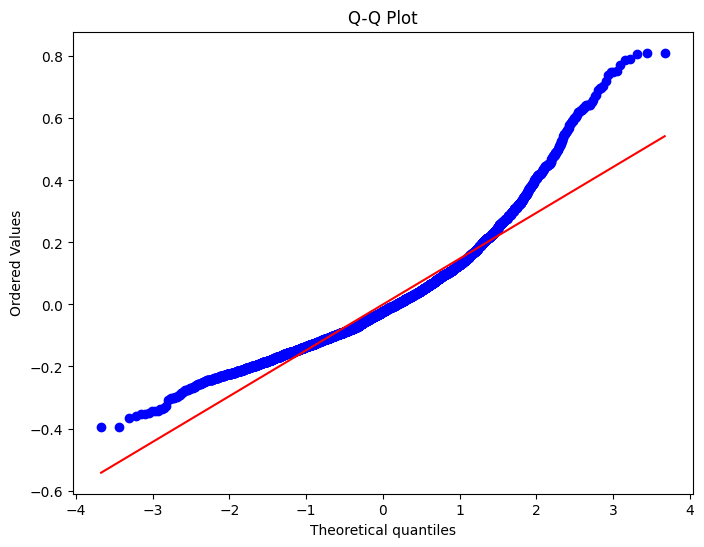

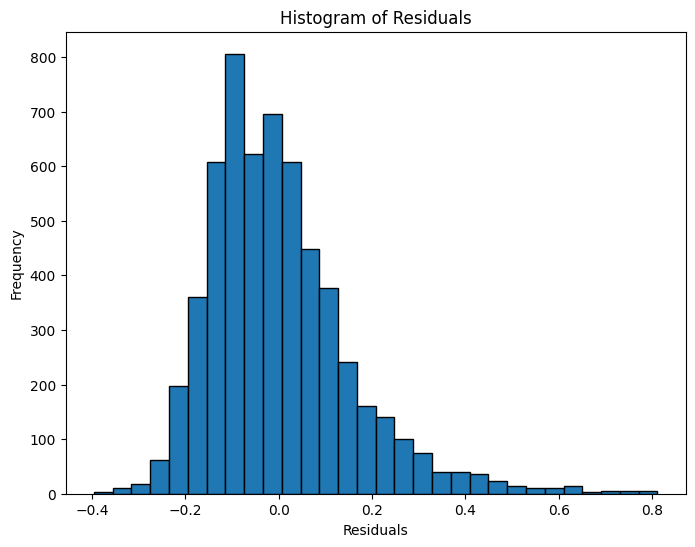

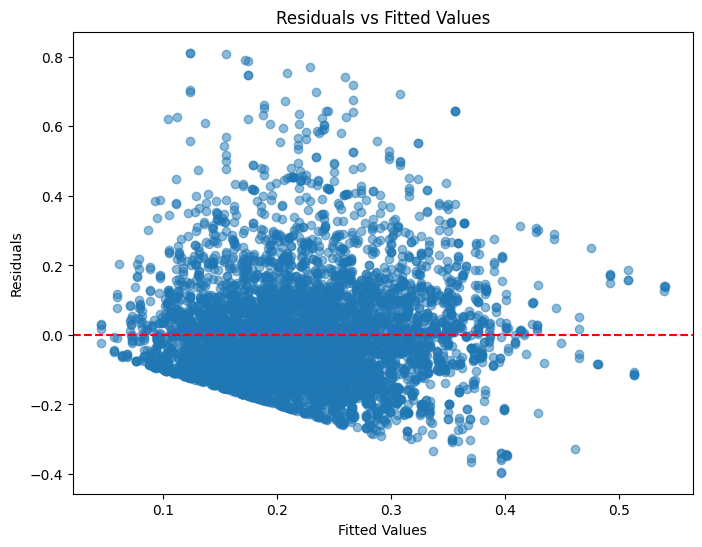

In [11]:
plot_residuals(result)

## mAP OLS Model with Interactions

In [12]:
mixed_model_int = (
    "score ~ judged_by * (QL + QDR + QW + DL + pipeline + C(LLM, Treatment(reference='Other'))) + "
    "isSynthetic * (QL + QDR + QW + DL + pipeline + C(LLM, Treatment(reference='Other')))"
)

In [13]:
model_int = sm.OLS.from_formula(mixed_model_int, data)
result_int = model_int.fit()
result_int.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     72.12
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:33:11   Log-Likelihood:                 2820.9
No. Observations:                5740   AIC:                            -5588.
Df Residuals:                    5713   BIC:                            -5408.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            0.2464      0.014     17.395      0.000       0.219       0.274
judged_by[T.nist]                                                   -0.0570      0.018     -3.225      0.001      -0.092      -0.022
C(LLM, Treatment(reference='Other'))[T.GPT]                         -0.0173      0.009     -1.860      0.063      -0.036       0.001
C(LLM, Treatment(reference='Other'))[T.T5]                          -0.0080      0.011     -0.713      0.476      -0.030       0.014
C(LLM, Treatment(reference='Other'))[T.T5+GPT]                       0.0566      0.009      6.600      0.000       0.040       0.073
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.GPT]       -0.0319      0.012     -2.773      0.006      -0.054      -0.009
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.T5]         0.0013      0.014      0.092      0.926      -0.026       0.028
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.T5+GPT]     0.0265      0.011      2.493      0.013       0.006       0.047
QL                                                                   0.1938      0.018     10.657      0.000       0.158       0.229
judged_by[T.nist]:QL                                                -0.0011      0.018     -0.060      0.952      -0.036       0.034
QDR                                                                 -0.0098      0.002     -4.212      0.000      -0.014      -0.005
judged_by[T.nist]:QDR                                               -0.0018      0.003     -0.553      0.580      -0.008       0.005
QW                                                                  -0.0205      0.002    -10.631      0.000      -0.024      -0.017
judged_by[T.nist]:QW                                                 0.0086      0.002      3.568      0.000       0.004       0.013
DL                                                                8.071e-05   4.73e-06     17.077      0.000    7.14e-05       9e-05
judged_by[T.nist]:DL                                             -3.917e-05   6.11e-06     -6.408      0.000   -5.12e-05   -2.72e-05
pipeline                                                             0.0164      0.002      8.786      0.000       0.013       0.020
judged_by[T.nist]:pipeline                                          -0.0008      0.002     -0.346      0.730      -0.005       0.004
isSynthetic                                                         -0.0374      0.019     -1.944      0.052      -0.075       0.000
isSynthetic:C(LLM, Treatment(reference='Other'))[T.GPT]             -0.0035      0.012     -0.294      0.769      -0.027       0.020
isSynthetic:C(LLM, Treat

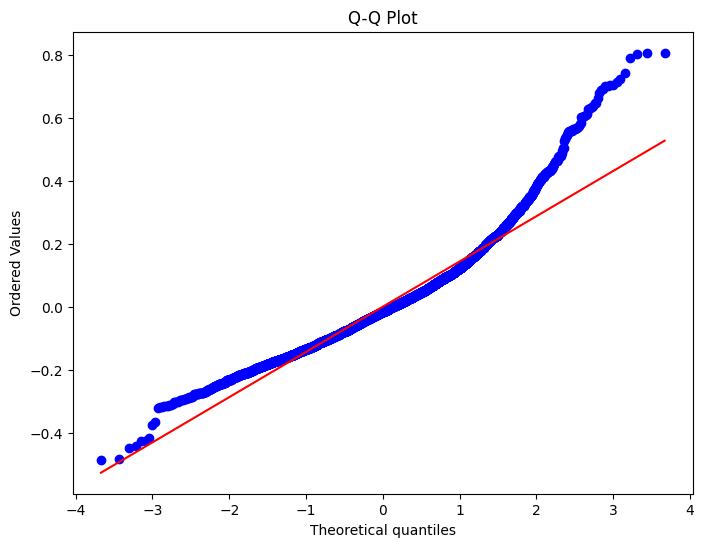

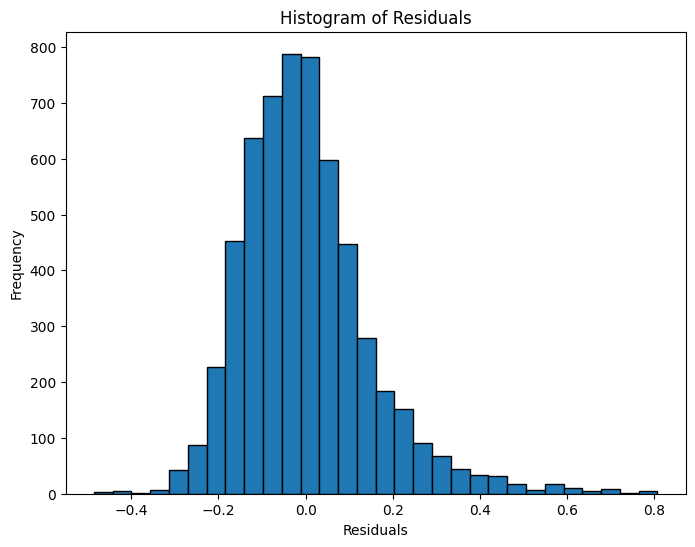

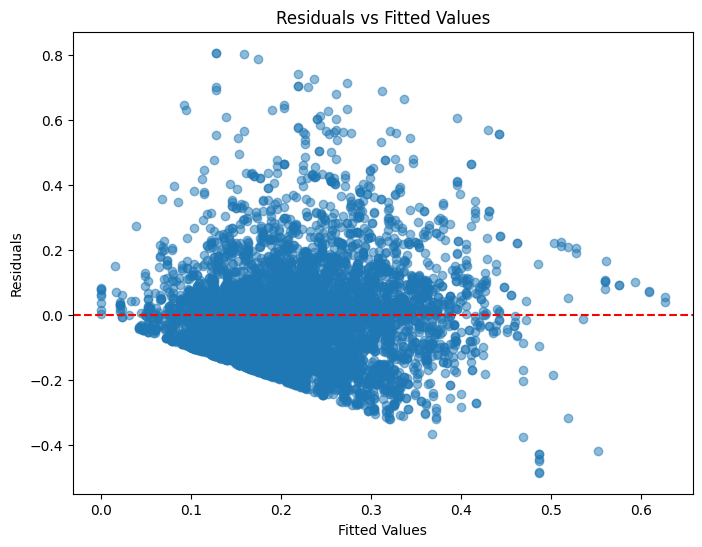

In [14]:
plot_residuals(result_int)

## mAP Score: Mixed Model

In [15]:
mixed_model = "score ~ judged_by + QL + QDR + QW + DL + isSynthetic + C(LLM, Treatment(reference='Other')) + pipeline"

In [16]:
model = sm.MixedLM.from_formula(mixed_model, data, groups=data["run_id"])
result = model.fit()
result.summary()

/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                        MixedLM            Dependent Variable:            score    
No. Observations:             5740               Method:                        REML     
No. Groups:                   35                 Scale:                         0.0226   
Min. group size:              164                Log-Likelihood:                2645.5814
Max. group size:              164                Converged:                     Yes      
Mean group size:              164.0                                                      
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                       0.210    0.015 13.909 0.000  0.180  0.239
judged_by[T.nist]                              -0.027    0.004 -6.694 0.000 -0.034 -0.019
C(LLM, Treatment(reference='Other'))[T.GPT]    -0.035    0.018 -1.913 0.056 -0.070  0.001
C(LLM, Treatment(reference='Other'))[T.T5]     -0.002    0.022 -0.077 0.939 -0.044  0.041
C(LLM, Treatment(reference='Other'))[T.T5+GPT]  0.079    0.017  4.737 0.000  0.046  0.112
QL                                              0.103    0.009 11.080 0.000  0.085  0.121
QDR                                            -0.015    0.002 -9.031 0.000 -0.018 -0.012
QW                                             -0.011    0.001 -9.281 0.000 -0.014 -0.009
DL                                              0.000    0.000 19.101 0.000  0.000  0.000
isSynthetic                                     0.000    0.005  0.039 0.969 -0.009  0.010
pipeline                                        0.016    0.004  4.432 0.000  0.009  0.023
Group Var                                       0.001    0.002                           
=========================================================================================

"""

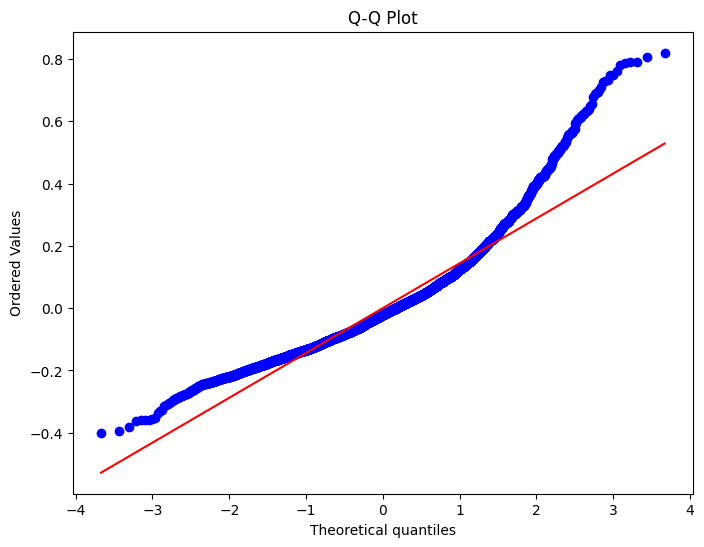

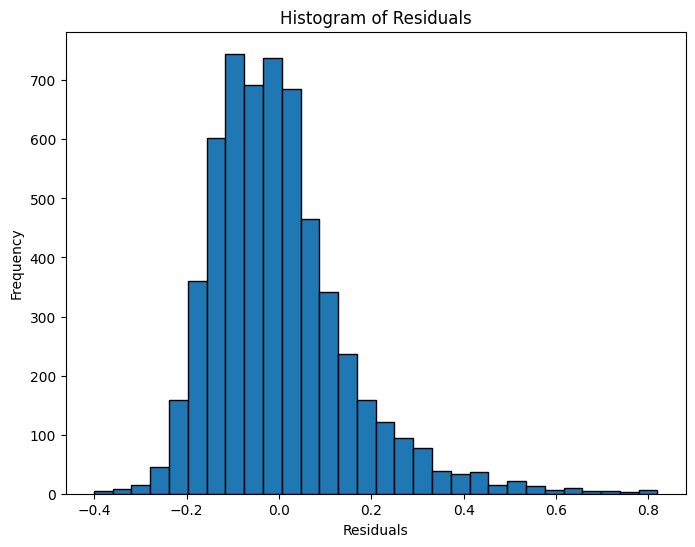

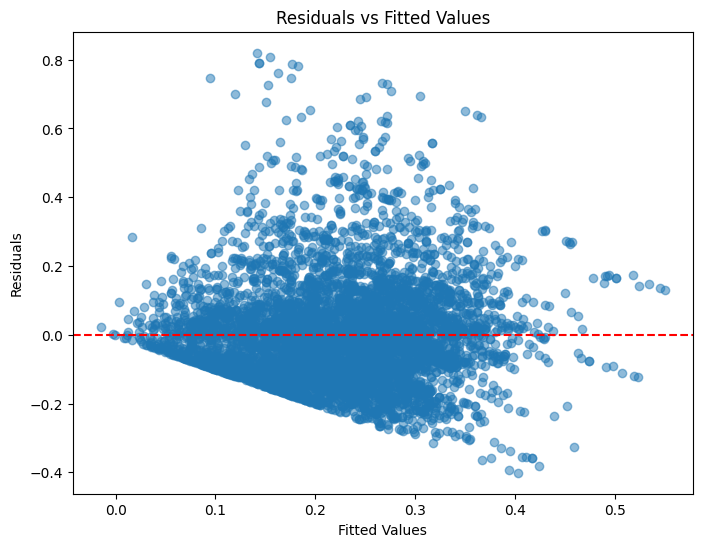

In [17]:
plot_residuals(result)

## mAP Score: Mixed Model with Interactions

In [18]:
mixed_model_int = (
    "score ~ judged_by * (QL + QDR + QW + DL + pipeline + C(LLM, Treatment(reference='Other'))) + "
    "isSynthetic * (QL + QDR + QW + DL + pipeline + C(LLM, Treatment(reference='Other')))"
)

In [19]:
model_int = sm.MixedLM.from_formula(mixed_model_int, data, groups=data["run_id"])
result_int = model_int.fit()
result_int.summary()

/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
============================================================================================================
Model:                               MixedLM                  Dependent Variable:                  score    
No. Observations:                    5740                     Method:                              REML     
No. Groups:                          35                       Scale:                               0.0210   
Min. group size:                     164                      Log-Likelihood:                      2781.8543
Max. group size:                     164                      Converged:                           Yes      
Mean group size:                     164.0                                                                  
------------------------------------------------------------------------------------------------------------
                                                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                                         0.246    0.018  13.470 0.000  0.211  0.282
judged_by[T.nist]                                                -0.057    0.017  -3.304 0.001 -0.091 -0.023
C(LLM, Treatment(reference='Other'))[T.GPT]                      -0.017    0.019  -0.890 0.373 -0.055  0.021
C(LLM, Treatment(reference='Other'))[T.T5]                       -0.008    0.023  -0.341 0.733 -0.054  0.038
C(LLM, Treatment(reference='Other'))[T.T5+GPT]                    0.057    0.018   3.158 0.002  0.021  0.092
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.GPT]    -0.032    0.011  -2.840 0.005 -0.054 -0.010
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.T5]      0.001    0.013   0.095 0.925 -0.025  0.028
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.T5+GPT]  0.027    0.010   2.554 0.011  0.006  0.047
QL                                                                0.194    0.018  10.916 0.000  0.159  0.229
judged_by[T.nist]:QL                                             -0.001    0.017  -0.062 0.951 -0.035  0.033
QDR                                                              -0.010    0.002  -4.314 0.000 -0.014 -0.005
judged_by[T.nist]:QDR                                            -0.002    0.003  -0.567 0.571 -0.008  0.004
QW                                                               -0.021    0.002 -10.889 0.000 -0.024 -0.017
judged_by[T.nist]:QW                                              0.009    0.002   3.654 0.000  0.004  0.013
DL                                                                0.000    0.000  17.491 0.000  0.000  0.000
judged_by[T.nist]:DL                                             -0.000    0.000  -6.563 0.000 -0.000 -0.000
pipeline                                                          0.016    0.004   4.204 0.000  0.009  0.024
judged_by[T.nist]:pipeline                                       -0.001    0.002  -0.354 0.723 -0.005  0.004
isSynthetic                                                      -0.037    0.019  -1.991 0.047 -0.074 -0.001
isSynthetic:C(LLM, Treatment(reference='Other'))[T.GPT]          -0.003    0.012  -0.301 0.763 -0.026  0.019
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5]            0.015    0.014   1.076 0.282 -0.012  0.042
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5+GPT]        0.024    0.011   2.262 0.024  0.003  0.045
isSynthetic:QL                                                   -0.159    0.021  -7.616 0.000 -0.200 -0.118
isSynthetic:QDR                                                  -0.123    0.008 -15.321 0.000 -0.139 -0.107
isSynthetic:QW                                                    0.017    0.003   6.400 0.000  0.012  0.022
isSynthetic:DL                                                 

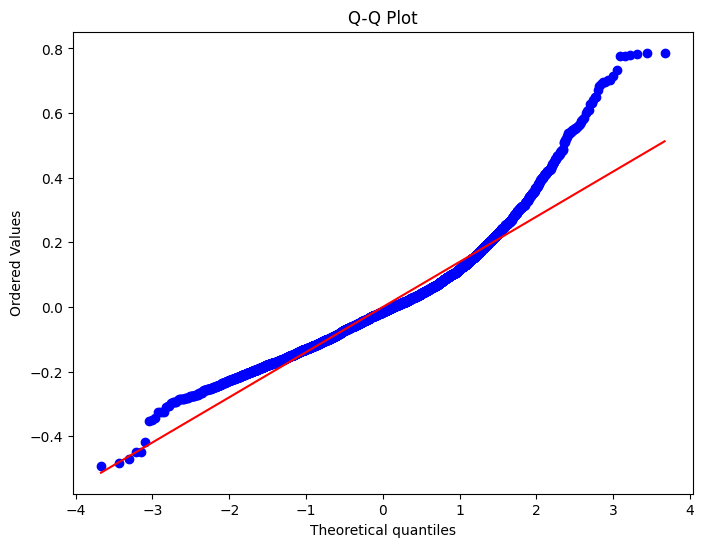

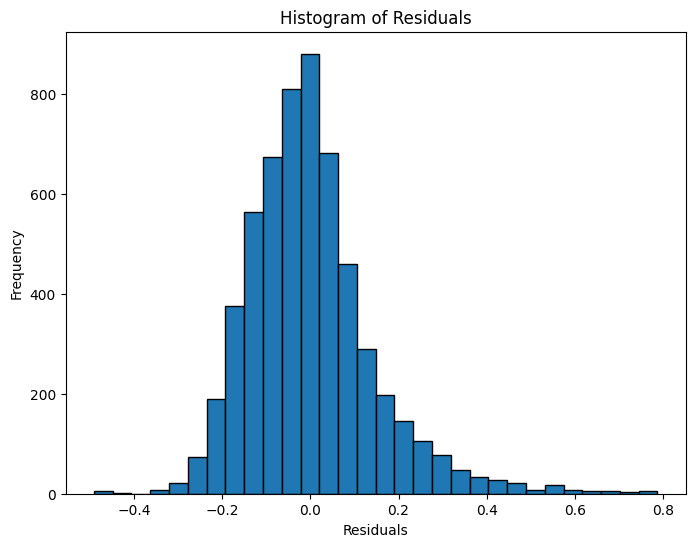

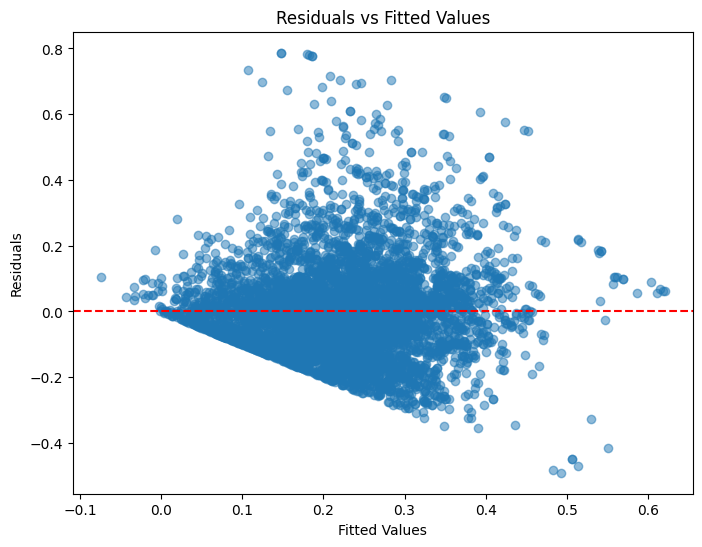

In [20]:
plot_residuals(result_int)

## mAP Score Difference

In [21]:
def get_result(result_file):
    result_df = pd.read_csv(result_file, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
    result_df = result_df[result_df['qid'] != 'all']
    result_df['metric'] = result_df['metric'].apply(lambda x: x.rstrip())
    result_df = result_df[(result_df['metric'] == metric)]
    result_df.drop(['metric'], axis=1, inplace=True)
    result_df['score'] = result_df['score'].astype(float)
    result_df['qid'] = result_df['qid'].astype(int)
    return result_df

In [22]:
real_judge_results = get_result(result_file=f"results/all.pass.nist.{result_format}")
synthetic_judge_results = get_result(result_file=f"results/all.pass.gpt4.{result_format}")

In [23]:
# Merging the dataframes on 'run_id' and 'qid'
results_diff = pd.merge(real_judge_results, synthetic_judge_results, on=['run_id', 'qid'], suffixes=('_real', '_synthetic'))
# Subtracting the 'Score' values
results_diff['score_RS'] = results_diff['score_real'] - results_diff['score_synthetic']
results_diff['score_SR'] = results_diff['score_synthetic'] - results_diff['score_real']

In [24]:
results_diff = pd.merge(results_diff, qid_to_info, on='qid')
results_diff = pd.merge(results_diff, model_to_info, on='run_id')

In [25]:
results_diff

,run_id,qid,score_real,score_synthetic,score_RS,score_SR,QL,QDR,QDS,QW,DL,isSynthetic,isGPT4,LLM,isLLM,pipeline
0,cip_run_7,2001010,0.7243,0.3724,0.3519,-0.3519,0,0.7840,0.7023,6,72.5291,0,0,GPT,1,2
1,cip_run_7,2001459,0.0773,0.1532,-0.0759,0.0759,0,2.6311,6.7917,4,57.2620,0,0,GPT,1,2
2,cip_run_7,2001575,0.2305,0.2898,-0.0593,0.0593,0,0.1040,0.7523,4,440.2367,0,0,GPT,1,2
3,cip_run_7,2002075,0.1900,0.1817,0.0083,-0.0083,0,1.8125,5.2791,7,1005.6332,0,0,GPT,1,2
4,cip_run_7,2002168,0.0963,0.1492,-0.0529,0.0529,0,1.3110,4.3667,7,56.8986,0,0,GPT,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,uogtr_b_grf_e_gb,3100825,0.0958,0.1451,-0.0493,0.0493,1,0.7835,4.0882,11,760.7758,1,1,T5,1,4
2866,uogtr_b_grf_e_gb,3100833,0.3054,0.3453,-0.0399,0.0399,1,0.1144,0.6350,13,702.7082,1,1,T5,1,4
2867,uogtr_b_grf_e_gb,3100909,0.1652,0.1485,0.0167,-0.0167,1,1.1883,2.7444,10,995.8028,1,1,T5,1,4
2868,uogtr_b_grf_e_gb,3100918,0.0807,0.1860,-0.1053,0.1053,1,0.4276,2.0563,10,143.9186,1,1,T5,1,4


In [26]:
results_diff['qd_RS'] = results_diff['QDR'] - results_diff['QDS']
results_diff['qd_SR'] = results_diff['QDS'] - results_diff['QDR']

## mAP Score Difference: Mixed Model with Interactions

In [27]:
mixed_model_d = (
    "score_SR ~ isSynthetic * (QL + qd_SR + QW + DL + pipeline + C(LLM, Treatment(reference='Other')))"
)

In [28]:
model_d = sm.MixedLM.from_formula(mixed_model_d, results_diff, groups=results_diff["run_id"])
result_d = model_d.fit()
result_d.summary()

/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Mixed Linear Model Regression Results
=====================================================================================================
Model:                            MixedLM                Dependent Variable:                score_SR 
No. Observations:                 2870                   Method:                            REML     
No. Groups:                       35                     Scale:                             0.0255   
Min. group size:                  82                     Log-Likelihood:                    1108.0909
Max. group size:                  82                     Converged:                         Yes      
Mean group size:                  82.0                                                               
-----------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                   0.071    0.016  4.448 0.000  0.040  0.103
C(LLM, Treatment(reference='Other'))[T.GPT]                 0.041    0.012  3.318 0.001  0.017  0.065
C(LLM, Treatment(reference='Other'))[T.T5]                  0.016    0.015  1.050 0.294 -0.014  0.045
C(LLM, Treatment(reference='Other'))[T.T5+GPT]             -0.038    0.011 -3.330 0.001 -0.061 -0.016
isSynthetic                                                -0.044    0.028 -1.588 0.112 -0.099  0.010
isSynthetic:C(LLM, Treatment(reference='Other'))[T.GPT]    -0.024    0.018 -1.347 0.178 -0.060  0.011
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5]     -0.045    0.022 -2.062 0.039 -0.087 -0.002
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5+GPT]  0.031    0.017  1.839 0.066 -0.002  0.063
QL                                                         -0.001    0.024 -0.033 0.973 -0.048  0.047
qd_SR                                                      -0.001    0.001 -0.486 0.627 -0.003  0.002
QW                                                         -0.010    0.002 -4.226 0.000 -0.014 -0.005
DL                                                          0.000    0.000  6.765 0.000  0.000  0.000
pipeline                                                   -0.001    0.002 -0.444 0.657 -0.006  0.004
isSynthetic:QL                                              0.001    0.033  0.021 0.984 -0.064  0.065
isSynthetic:qd_SR                                           0.005    0.003  1.665 0.096 -0.001  0.010
isSynthetic:QW                                              0.003    0.004  0.602 0.547 -0.006  0.011
isSynthetic:DL                                              0.000    0.000  0.444 0.657 -0.000  0.000
isSynthetic:pipeline                                        0.005    0.004  1.389 0.165 -0.002  0.012
Group Var                                                   0.000    0.001                           
=====================================================================================================

"""

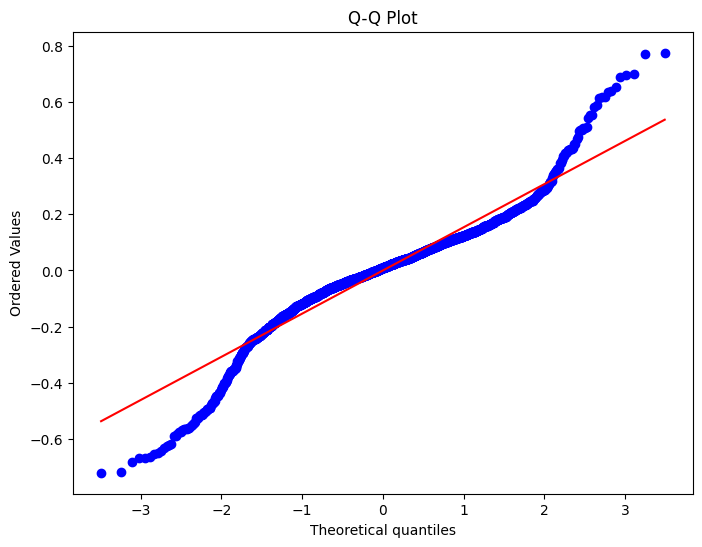

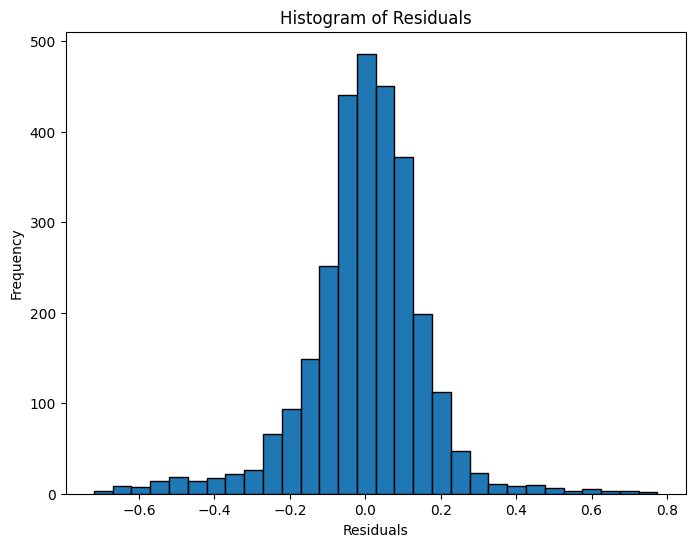

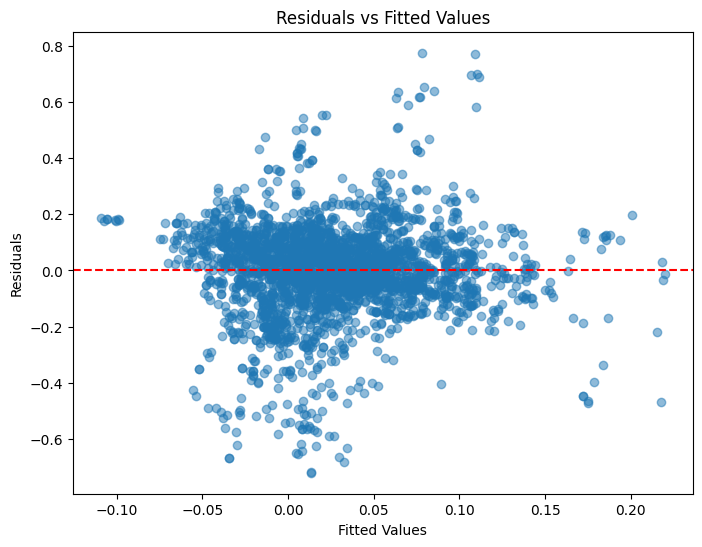

In [29]:
plot_residuals(result_d)

## mAP Score Difference: OLS Model with Interactions

In [30]:
model_d = sm.OLS.from_formula(mixed_model_d, results_diff)
result_d = model_d.fit()
result_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               score_SR   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     12.76
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           3.36e-35
Time:                        15:33:12   Log-Likelihood:                 1197.2
No. Observations:                2870   AIC:                            -2358.
Df Residuals:                    2852   BIC:                            -2251.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      0.0714      0.016      4.571      0.000       0.041       0.102
C(LLM, Treatment(reference='Other'))[T.GPT]                    0.0411      0.011      3.695      0.000       0.019       0.063
C(LLM, Treatment(reference='Other'))[T.T5]                     0.0156      0.013      1.170      0.242      -0.011       0.042
C(LLM, Treatment(reference='Other'))[T.T5+GPT]                -0.0381      0.010     -3.708      0.000      -0.058      -0.018
isSynthetic                                                   -0.0444      0.028     -1.585      0.113      -0.099       0.011
isSynthetic:C(LLM, Treatment(reference='Other'))[T.GPT]       -0.0243      0.018     -1.345      0.179      -0.060       0.011
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5]        -0.0447      0.022     -2.058      0.040      -0.087      -0.002
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5+GPT]     0.0307      0.017      1.835      0.067      -0.002       0.063
QL                                                            -0.0008      0.024     -0.033      0.973      -0.048       0.047
qd_SR                                                         -0.0006      0.001     -0.485      0.628      -0.003       0.002
QW                                                            -0.0095      0.002     -4.218      0.000      -0.014      -0.005
DL                                                           3.75e-05   5.56e-06      6.751      0.000    2.66e-05    4.84e-05
pipeline                                                      -0.0011      0.002     -0.495      0.621      -0.005       0.003
isSynthetic:QL                                                 0.0007      0.033      0.021      0.984      -0.064       0.065
isSynthetic:qd_SR                                              0.0046      0.003      1.661      0.097      -0.001       0.010
isSynthetic:QW                                                 0.0025      0.004      0.600      0.548      -0.006       0.011
isSynthetic:DL                                              5.528e-06   1.25e-05      0.443      0.658   -1.89e-05       3e-05
isSynthetic:pipeline                                           0.0050      0.004      1.387      0.166      -0.002       0.012
==============================================================================
Omnibus:                      343.996   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1700.712
Skew:                          -0.468   Prob(JB):                         0.00
Kurtosis:                       6.653   Cond. No.                     1.35e+04
=====================

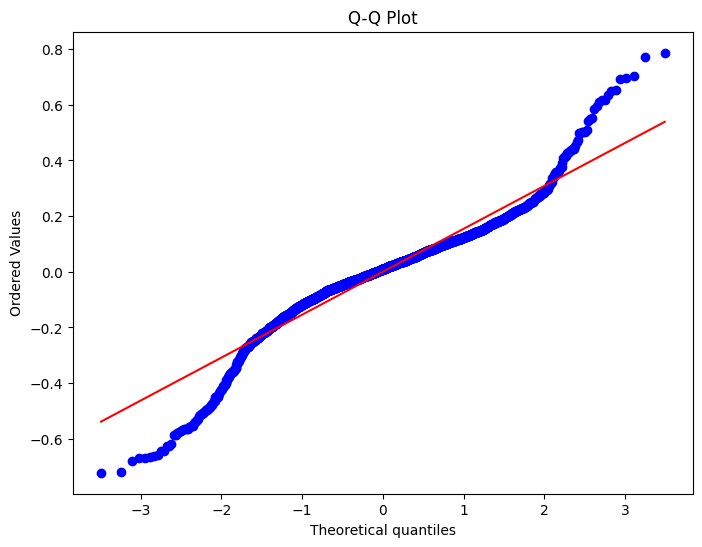

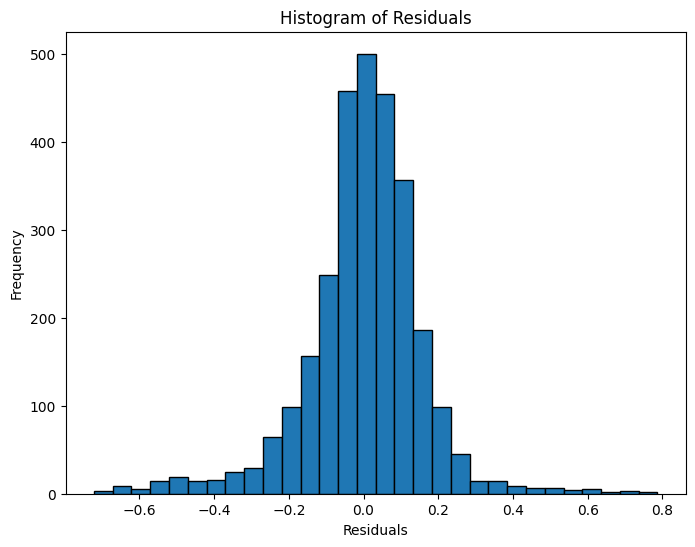

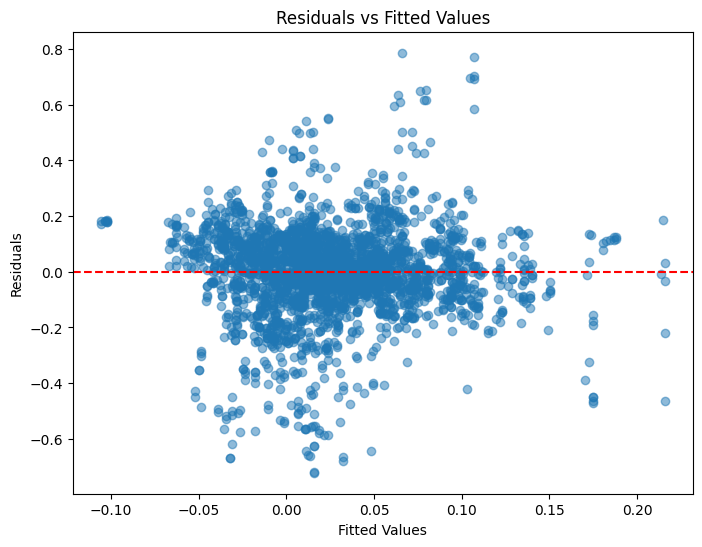

In [31]:
plot_residuals(result_d)

# NDCG@10 Score

In [32]:
metric = "ndcg_cut_10" # map # ndcg_cut_10
result_format = "ndcgeval" # treceval # ndcgeval

In [33]:
results_df_list = []

for infile in glob.glob(f'./results/*.{result_format}'):
    judger = infile.split('/')[2].split('.')[2]
    result_df = pd.read_csv(infile, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
    result_df = result_df[result_df['qid'] != 'all']
    result_df['metric'] = result_df['metric'].apply(lambda x: x.rstrip())
    result_df = result_df[(result_df['metric'] == metric)]
    result_df.drop(['metric'], axis=1, inplace=True)
    result_df['judged_by'] = judger
    result_df['qid'] = result_df['qid'].astype(int)
    result_df['score'] = result_df['score'].astype(float)
    results_df_list.append(result_df)
 
results_dfs = pd.concat(results_df_list)
results_dfs

,run_id,qid,score,judged_by
2,cip_run_7,2001010,0.8563,nist
12,cip_run_7,2001459,0.6551,nist
22,cip_run_7,2001575,0.3321,nist
32,cip_run_7,2002075,0.8087,nist
42,cip_run_7,2002168,0.6691,nist
...,...,...,...,...
28992,naverloo_bm25_splades_RR,3100825,0.7797,gpt4
29002,naverloo_bm25_splades_RR,3100833,0.8526,gpt4
29012,naverloo_bm25_splades_RR,3100909,0.9373,gpt4
29022,naverloo_bm25_splades_RR,3100918,0.9402,gpt4


In [34]:
qid_to_info = pd.read_csv("infos/query_to_info.txt", sep='\t')
doc_to_info = pd.read_csv("infos/doc_to_info.txt", sep='\t')
model_to_info = pd.read_csv("infos/model_to_info.txt", sep='\t')

In [35]:
queries_judged = set(results_dfs['qid'])
real_queries_judged = [x for x in queries_judged if x < 3000000]
t5_queries_judged = [x for x in queries_judged if x > 3000000 and x < 3100000]
gpt4_queries_judged = [x for x in queries_judged if x > 3100000]

In [36]:
data = pd.merge(results_dfs, qid_to_info, on='qid')
# data = pd.merge(data, doc_to_info, on='qid')
data = pd.merge(data, model_to_info, on='run_id')

In [37]:
data

,run_id,qid,score,judged_by,QL,QDR,QDS,QW,DL,isSynthetic,isGPT4,LLM,isLLM,pipeline
0,cip_run_7,2001010,0.8563,nist,0,0.7840,0.7023,6,72.5291,0,0,GPT,1,2
1,cip_run_7,2001459,0.6551,nist,0,2.6311,6.7917,4,57.2620,0,0,GPT,1,2
2,cip_run_7,2001575,0.3321,nist,0,0.1040,0.7523,4,440.2367,0,0,GPT,1,2
3,cip_run_7,2002075,0.8087,nist,0,1.8125,5.2791,7,1005.6332,0,0,GPT,1,2
4,cip_run_7,2002168,0.6691,nist,0,1.3110,4.3667,7,56.8986,0,0,GPT,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5735,naverloo_bm25_splades_RR,3100825,0.7797,gpt4,1,0.7835,4.0882,11,760.7758,1,1,T5,1,8
5736,naverloo_bm25_splades_RR,3100833,0.8526,gpt4,1,0.1144,0.6350,13,702.7082,1,1,T5,1,8
5737,naverloo_bm25_splades_RR,3100909,0.9373,gpt4,1,1.1883,2.7444,10,995.8028,1,1,T5,1,8
5738,naverloo_bm25_splades_RR,3100918,0.9402,gpt4,1,0.4276,2.0563,10,143.9186,1,1,T5,1,8


## NDCG@10 Score: Mixed Model 

In [38]:
mixed_model = "score ~ judged_by + QL + QDR + QW + DL + isSynthetic + C(LLM, Treatment(reference='Other')) + pipeline"

In [39]:
model = sm.MixedLM.from_formula(mixed_model, data, groups=data["run_id"])
result = model.fit()
result.summary()

/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                        MixedLM             Dependent Variable:             score   
No. Observations:             5740                Method:                         REML    
No. Groups:                   35                  Scale:                          0.0420  
Min. group size:              164                 Log-Likelihood:                 854.0988
Max. group size:              164                 Converged:                      Yes     
Mean group size:              164.0                                                       
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                       0.622    0.029  21.375 0.000  0.565  0.679
judged_by[T.nist]                              -0.201    0.005 -37.144 0.000 -0.212 -0.190
C(LLM, Treatment(reference='Other'))[T.GPT]    -0.067    0.038  -1.729 0.084 -0.142  0.009
C(LLM, Treatment(reference='Other'))[T.T5]      0.038    0.046   0.827 0.408 -0.052  0.129
C(LLM, Treatment(reference='Other'))[T.T5+GPT]  0.168    0.036   4.720 0.000  0.098  0.237
QL                                              0.044    0.013   3.444 0.001  0.019  0.068
QDR                                             0.025    0.002  11.245 0.000  0.021  0.030
QW                                              0.001    0.002   0.793 0.428 -0.002  0.005
DL                                             -0.000    0.000  -8.177 0.000 -0.000 -0.000
isSynthetic                                    -0.051    0.007  -7.734 0.000 -0.063 -0.038
pipeline                                        0.019    0.008   2.465 0.014  0.004  0.034
Group Var                                       0.006    0.008                            
==========================================================================================

"""

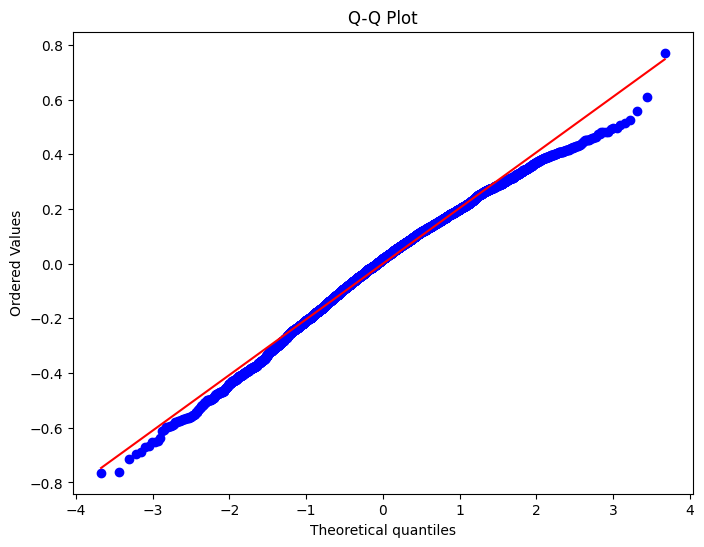

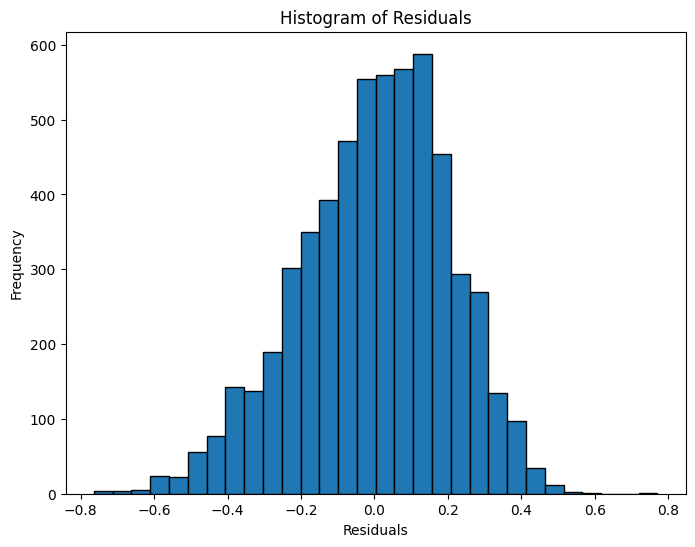

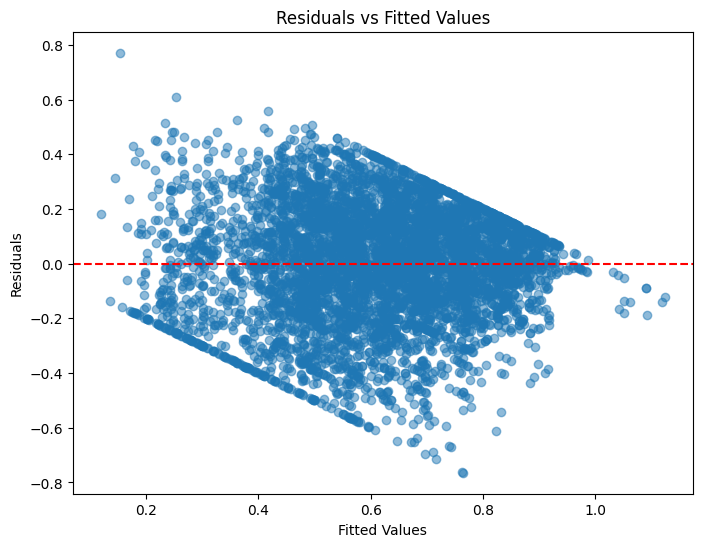

In [40]:
plot_residuals(result)

## NCDG@10 Score: OLS Model 

In [41]:
model = sm.OLS.from_formula(mixed_model, data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     269.0
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:33:13   Log-Likelihood:                 640.43
No. Observations:                5740   AIC:                            -1259.
Df Residuals:                    5729   BIC:                            -1186.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.6217      0.013     46.780      0.000       0.596       0.648
judged_by[T.nist]                                 -0.2010      0.006    -35.141      0.000      -0.212      -0.190
C(LLM, Treatment(reference='Other'))[T.GPT]       -0.0665      0.008     -7.913      0.000      -0.083      -0.050
C(LLM, Treatment(reference='Other'))[T.T5]         0.0382      0.010      3.787      0.000       0.018       0.058
C(LLM, Treatment(reference='Other'))[T.T5+GPT]     0.1676      0.008     21.604      0.000       0.152       0.183
QL                                                 0.0436      0.013      3.259      0.001       0.017       0.070
QDR                                                0.0252      0.002     10.638      0.000       0.021       0.030
QW                                                 0.0013      0.002      0.751      0.453      -0.002       0.005
DL                                             -3.465e-05   4.48e-06     -7.736      0.000   -4.34e-05   -2.59e-05
isSynthetic                                       -0.0506      0.007     -7.317      0.000      -0.064      -0.037
pipeline                                           0.0190      0.002     11.280      0.000       0.016       0.022
==============================================================================
Omnibus:                      120.992   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.316
Skew:                          -0.353   Prob(JB):                     3.72e-28
Kurtosis:                       2.829   Cond. No.                     5.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

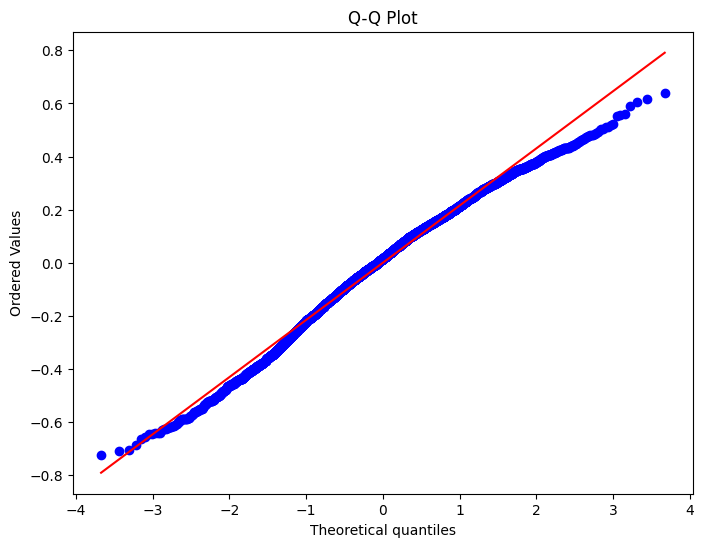

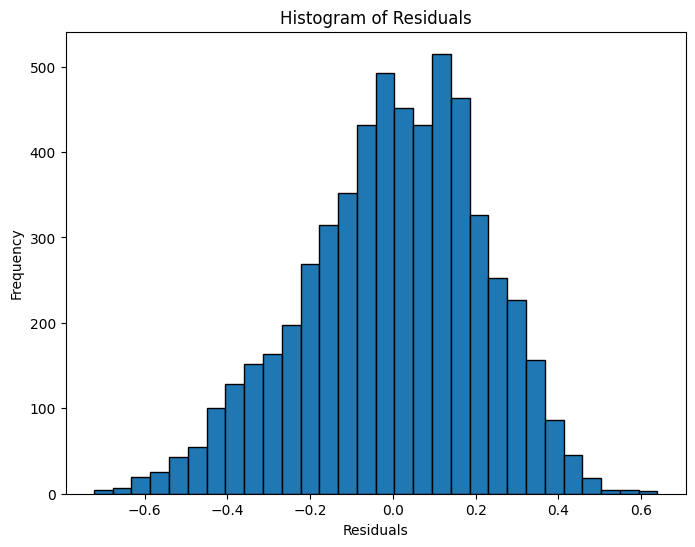

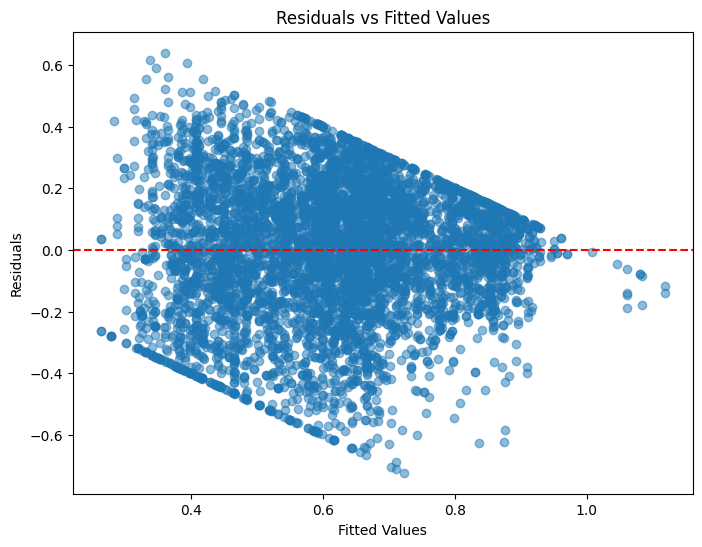

In [42]:
plot_residuals(result)

## NDCG@10 Score: Mixed Model with Interactions

In [43]:
mixed_model_int = (
    "score ~ judged_by * (QL + QDR + QW + DL + pipeline + C(LLM, Treatment(reference='Other'))) + "
    "isSynthetic * (QL + QDR + QW + DL + pipeline + C(LLM, Treatment(reference='Other')))"
)

In [44]:
model_int = sm.MixedLM.from_formula(mixed_model_int, data, groups=data["run_id"])
result_int = model_int.fit()
result_int.summary()

/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
===========================================================================================================
Model:                               MixedLM                  Dependent Variable:                  score   
No. Observations:                    5740                     Method:                              REML    
No. Groups:                          35                       Scale:                               0.0412  
Min. group size:                     164                      Log-Likelihood:                      840.4420
Max. group size:                     164                      Converged:                           Yes     
Mean group size:                     164.0                                                                 
-----------------------------------------------------------------------------------------------------------
                                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                         0.575    0.033 17.631 0.000  0.511  0.639
judged_by[T.nist]                                                -0.190    0.024 -7.860 0.000 -0.237 -0.143
C(LLM, Treatment(reference='Other'))[T.GPT]                      -0.059    0.040 -1.475 0.140 -0.137  0.019
C(LLM, Treatment(reference='Other'))[T.T5]                        0.039    0.048  0.819 0.413 -0.054  0.132
C(LLM, Treatment(reference='Other'))[T.T5+GPT]                    0.165    0.037  4.485 0.000  0.093  0.236
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.GPT]    -0.018    0.016 -1.150 0.250 -0.049  0.013
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.T5]     -0.008    0.019 -0.406 0.685 -0.045  0.029
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.T5+GPT] -0.003    0.015 -0.221 0.825 -0.032  0.025
QL                                                               -0.024    0.025 -0.949 0.343 -0.072  0.025
judged_by[T.nist]:QL                                              0.060    0.025  2.453 0.014  0.012  0.108
QDR                                                               0.023    0.003  7.164 0.000  0.017  0.029
judged_by[T.nist]:QDR                                             0.008    0.004  1.754 0.079 -0.001  0.016
QW                                                                0.011    0.003  4.117 0.000  0.006  0.016
judged_by[T.nist]:QW                                             -0.009    0.003 -2.570 0.010 -0.015 -0.002
DL                                                               -0.000    0.000 -6.725 0.000 -0.000 -0.000
judged_by[T.nist]:DL                                              0.000    0.000  6.650 0.000  0.000  0.000
pipeline                                                          0.019    0.008  2.364 0.018  0.003  0.035
judged_by[T.nist]:pipeline                                       -0.000    0.003 -0.060 0.952 -0.006  0.006
isSynthetic                                                       0.027    0.026  1.039 0.299 -0.024  0.079
isSynthetic:C(LLM, Treatment(reference='Other'))[T.GPT]           0.003    0.016  0.188 0.851 -0.029  0.035
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5]            0.008    0.019  0.400 0.689 -0.030  0.046
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5+GPT]        0.012    0.015  0.829 0.407 -0.017  0.042
isSynthetic:QL                                                    0.059    0.029  2.036 0.042  0.002  0.117
isSynthetic:QDR                                                  -0.009    0.011 -0.838 0.402 -0.031  0.013
isSynthetic:QW                                                   -0.007    0.004 -1.970 0.049 -0.015 -0.000
isSynthetic:DL                                                   -0.000    0.000 -6.932 0.000 -0.0

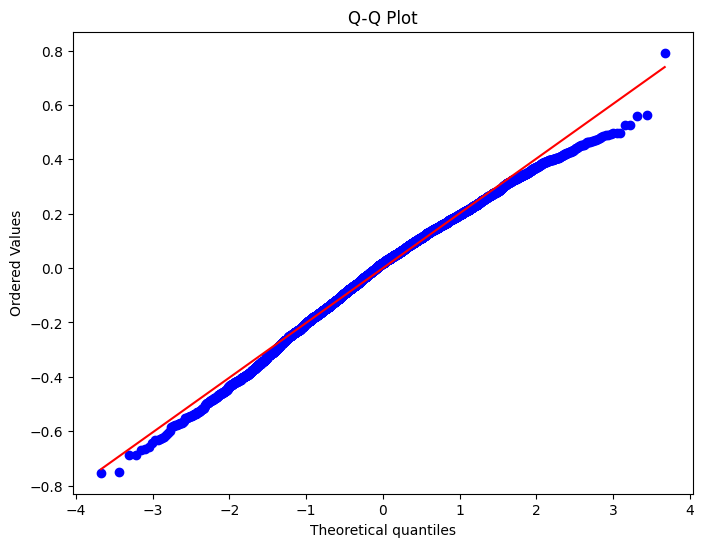

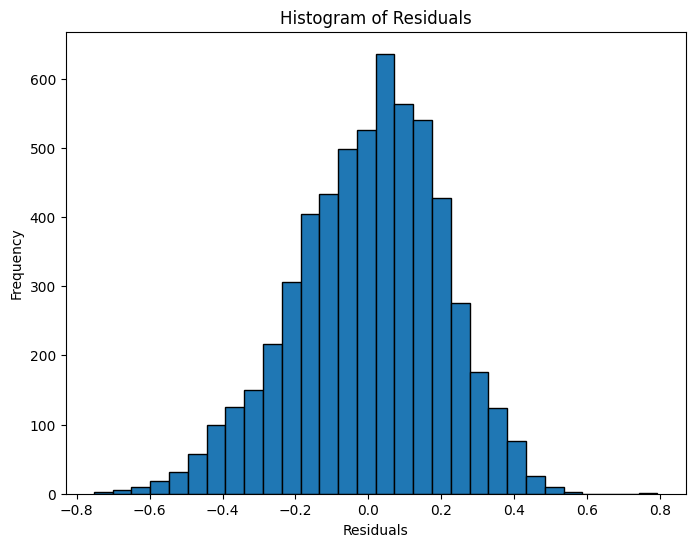

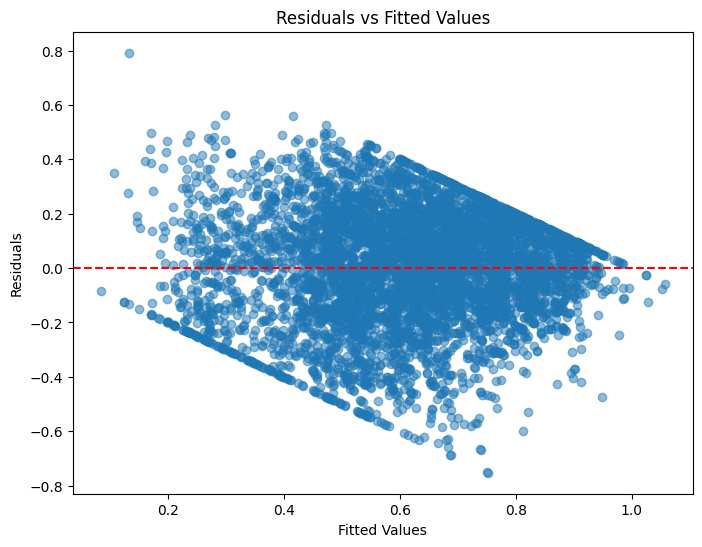

In [45]:
plot_residuals(result_int)

## NCDG Score: OLS Model With Interactions

In [46]:
model_int = sm.OLS.from_formula(mixed_model_int, data, groups=data["run_id"])
result_int = model_int.fit()
result_int.summary()

/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     109.4
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:33:13   Log-Likelihood:                 695.37
No. Observations:                5740   AIC:                            -1337.
Df Residuals:                    5713   BIC:                            -1157.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            0.5751      0.021     28.041      0.000       0.535       0.615
judged_by[T.nist]                                                   -0.1901      0.026     -7.427      0.000      -0.240      -0.140
C(LLM, Treatment(reference='Other'))[T.GPT]                         -0.0586      0.013     -4.354      0.000      -0.085      -0.032
C(LLM, Treatment(reference='Other'))[T.T5]                           0.0391      0.016      2.419      0.016       0.007       0.071
C(LLM, Treatment(reference='Other'))[T.T5+GPT]                       0.1645      0.012     13.239      0.000       0.140       0.189
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.GPT]       -0.0181      0.017     -1.087      0.277      -0.051       0.015
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.T5]        -0.0077      0.020     -0.383      0.701      -0.047       0.032
judged_by[T.nist]:C(LLM, Treatment(reference='Other'))[T.T5+GPT]    -0.0032      0.015     -0.209      0.835      -0.033       0.027
QL                                                                  -0.0236      0.026     -0.896      0.370      -0.075       0.028
judged_by[T.nist]:QL                                                 0.0601      0.026      2.318      0.021       0.009       0.111
QDR                                                                  0.0228      0.003      6.769      0.000       0.016       0.029
judged_by[T.nist]:QDR                                                0.0077      0.005      1.657      0.098      -0.001       0.017
QW                                                                   0.0109      0.003      3.891      0.000       0.005       0.016
judged_by[T.nist]:QW                                                -0.0085      0.004     -2.429      0.015      -0.015      -0.002
DL                                                                -4.35e-05   6.84e-06     -6.355      0.000   -5.69e-05   -3.01e-05
judged_by[T.nist]:DL                                              5.563e-05   8.85e-06      6.284      0.000    3.83e-05     7.3e-05
pipeline                                                             0.0189      0.003      6.979      0.000       0.014       0.024
judged_by[T.nist]:pipeline                                          -0.0002      0.003     -0.057      0.955      -0.007       0.006
isSynthetic                                                          0.0274      0.028      0.981      0.326      -0.027       0.082
isSynthetic:C(LLM, Treatment(reference='Other'))[T.GPT]              0.0031      0.017      0.178      0.859      -0.031       0.037
isSynthetic:C(LLM, Treat

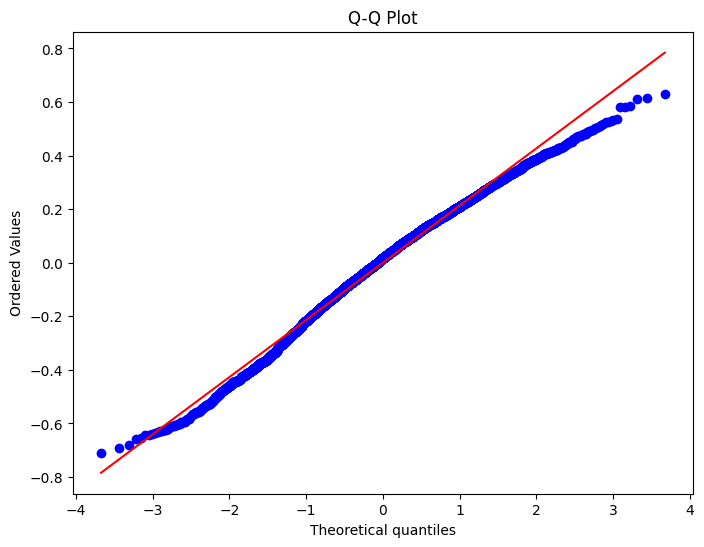

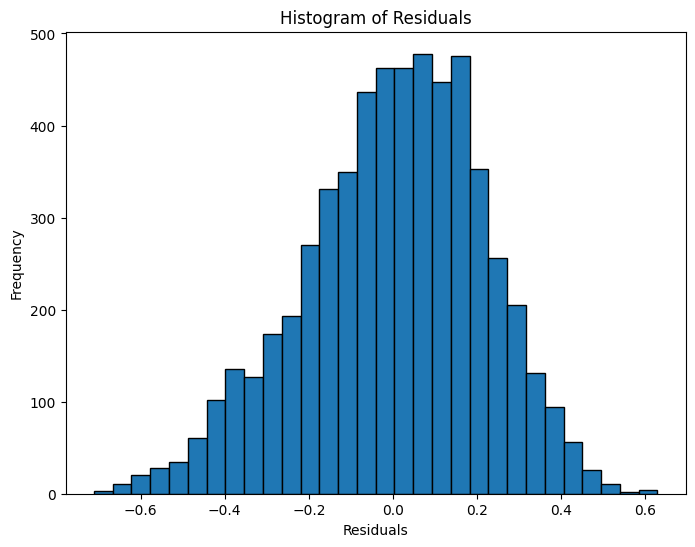

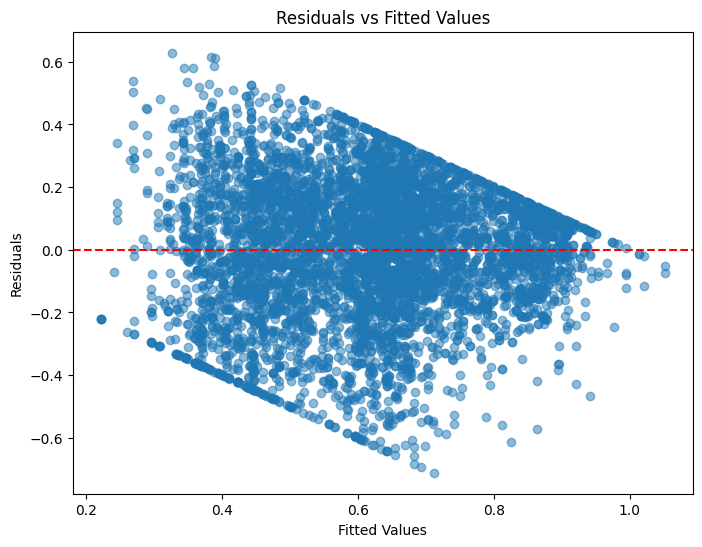

In [47]:
plot_residuals(result_int)

# NDCG@10 Score Difference

In [48]:
def get_result(result_file):
    result_df = pd.read_csv(result_file, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
    result_df = result_df[result_df['qid'] != 'all']
    result_df['metric'] = result_df['metric'].apply(lambda x: x.rstrip())
    result_df = result_df[(result_df['metric'] == metric)]
    result_df.drop(['metric'], axis=1, inplace=True)
    result_df['score'] = result_df['score'].astype(float)
    result_df['qid'] = result_df['qid'].astype(int)
    return result_df

In [49]:
real_judge_results = get_result(result_file=f"results/all.pass.nist.{result_format}")
synthetic_judge_results = get_result(result_file=f"results/all.pass.gpt4.{result_format}")

In [50]:
# Merging the dataframes on 'run_id' and 'qid'
results_diff = pd.merge(real_judge_results, synthetic_judge_results, on=['run_id', 'qid'], suffixes=('_real', '_synthetic'))
# Subtracting the 'Score' values
results_diff['score_RS'] = results_diff['score_real'] - results_diff['score_synthetic']
results_diff['score_SR'] = results_diff['score_synthetic'] - results_diff['score_real']

In [51]:
results_diff = pd.merge(results_diff, qid_to_info, on='qid')
results_diff = pd.merge(results_diff, model_to_info, on='run_id')

In [52]:
results_diff

,run_id,qid,score_real,score_synthetic,score_RS,score_SR,QL,QDR,QDS,QW,DL,isSynthetic,isGPT4,LLM,isLLM,pipeline
0,cip_run_7,2001010,0.8563,0.7281,0.1282,-0.1282,0,0.7840,0.7023,6,72.5291,0,0,GPT,1,2
1,cip_run_7,2001459,0.6551,0.9303,-0.2752,0.2752,0,2.6311,6.7917,4,57.2620,0,0,GPT,1,2
2,cip_run_7,2001575,0.3321,0.9299,-0.5978,0.5978,0,0.1040,0.7523,4,440.2367,0,0,GPT,1,2
3,cip_run_7,2002075,0.8087,1.0000,-0.1913,0.1913,0,1.8125,5.2791,7,1005.6332,0,0,GPT,1,2
4,cip_run_7,2002168,0.6691,0.9537,-0.2846,0.2846,0,1.3110,4.3667,7,56.8986,0,0,GPT,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,uogtr_b_grf_e_gb,3100825,0.5348,0.6676,-0.1328,0.1328,1,0.7835,4.0882,11,760.7758,1,1,T5,1,4
2866,uogtr_b_grf_e_gb,3100833,0.4907,0.8526,-0.3619,0.3619,1,0.1144,0.6350,13,702.7082,1,1,T5,1,4
2867,uogtr_b_grf_e_gb,3100909,0.9511,0.8671,0.0840,-0.0840,1,1.1883,2.7444,10,995.8028,1,1,T5,1,4
2868,uogtr_b_grf_e_gb,3100918,0.6336,0.9472,-0.3136,0.3136,1,0.4276,2.0563,10,143.9186,1,1,T5,1,4


Selected: score_SR

In [53]:
results_diff['qd_RS'] = results_diff['QDR'] - results_diff['QDS']
results_diff['qd_SR'] = results_diff['QDS'] - results_diff['QDR']

## NCDG@10 Score Difference: Mixed Model with Interactions

In [54]:
mixed_model_d = (
    "score_SR ~ isSynthetic * (QL + qd_SR + QW + DL + pipeline + C(LLM, Treatment(reference='Other')))"
)

In [55]:
model_d = sm.MixedLM.from_formula(mixed_model_d, results_diff, groups=results_diff["run_id"])
result_d = model_d.fit()
result_d.summary()

/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Mixed Linear Model Regression Results
=====================================================================================================
Model:                             MixedLM                Dependent Variable:                score_SR
No. Observations:                  2870                   Method:                            REML    
No. Groups:                        35                     Scale:                             0.0435  
Min. group size:                   82                     Log-Likelihood:                    351.6738
Max. group size:                   82                     Converged:                         Yes     
Mean group size:                   82.0                                                              
-----------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                   0.186    0.020  9.134 0.000  0.146  0.226
C(LLM, Treatment(reference='Other'))[T.GPT]                 0.038    0.015  2.589 0.010  0.009  0.066
C(LLM, Treatment(reference='Other'))[T.T5]                  0.023    0.017  1.324 0.186 -0.011  0.057
C(LLM, Treatment(reference='Other'))[T.T5+GPT]              0.015    0.013  1.107 0.268 -0.011  0.041
isSynthetic                                                -0.143    0.036 -3.924 0.000 -0.215 -0.072
isSynthetic:C(LLM, Treatment(reference='Other'))[T.GPT]    -0.051    0.024 -2.179 0.029 -0.098 -0.005
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5]     -0.041    0.028 -1.436 0.151 -0.096  0.015
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5+GPT] -0.031    0.022 -1.411 0.158 -0.073  0.012
QL                                                         -0.046    0.032 -1.470 0.142 -0.108  0.015
qd_SR                                                       0.012    0.002  7.364 0.000  0.009  0.015
QW                                                          0.003    0.003  1.144 0.253 -0.002  0.009
DL                                                         -0.000    0.000 -6.255 0.000 -0.000 -0.000
pipeline                                                    0.000    0.003  0.094 0.925 -0.005  0.006
isSynthetic:QL                                              0.022    0.043  0.515 0.607 -0.062  0.106
isSynthetic:qd_SR                                           0.034    0.004  9.414 0.000  0.027  0.041
isSynthetic:QW                                              0.008    0.005  1.474 0.140 -0.003  0.019
isSynthetic:DL                                              0.000    0.000  1.764 0.078 -0.000  0.000
isSynthetic:pipeline                                       -0.000    0.005 -0.046 0.963 -0.010  0.009
Group Var                                                   0.000                                    
=====================================================================================================

"""

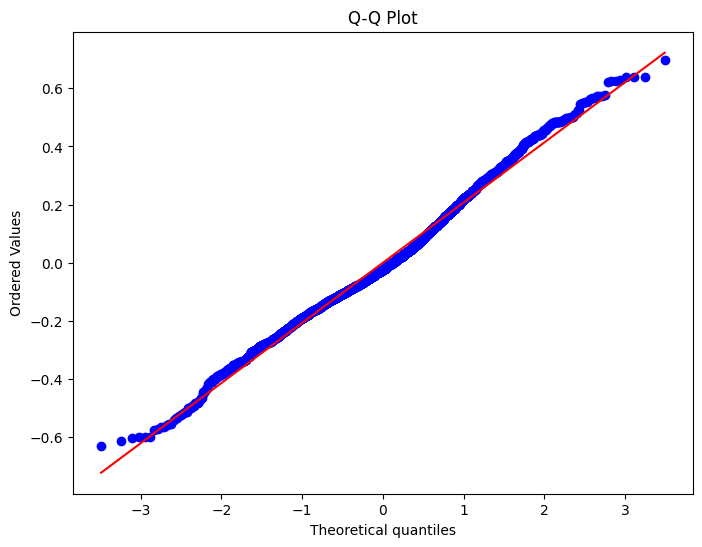

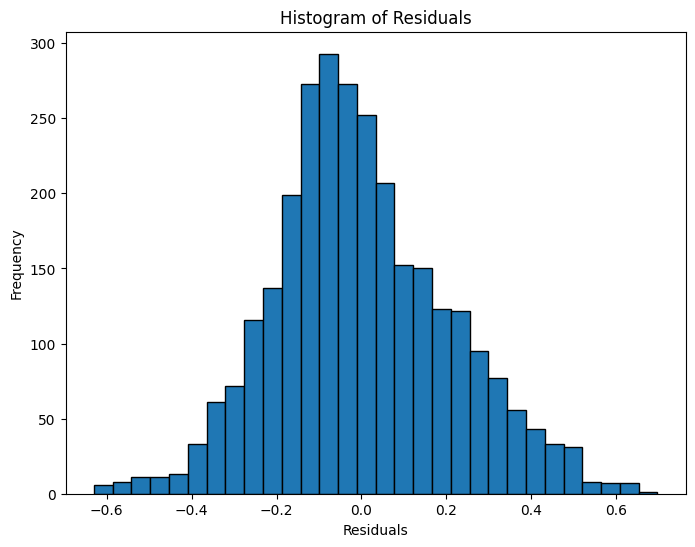

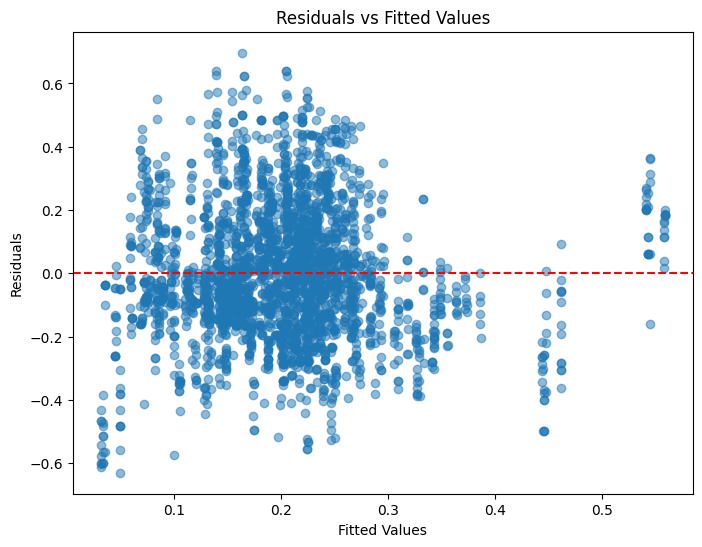

In [56]:
plot_residuals(result_d)

## NCDG@10 Score Difference: OLS Model with Interactions

In [57]:
model_d = sm.OLS.from_formula(mixed_model_d, results_diff)
result_d = model_d.fit()
result_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               score_SR   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     24.63
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           1.01e-72
Time:                        15:33:14   Log-Likelihood:                 436.98
No. Observations:                2870   AIC:                            -838.0
Df Residuals:                    2852   BIC:                            -730.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      0.1861      0.020      9.134      0.000       0.146       0.226
C(LLM, Treatment(reference='Other'))[T.GPT]                    0.0375      0.015      2.589      0.010       0.009       0.066
C(LLM, Treatment(reference='Other'))[T.T5]                     0.0230      0.017      1.324      0.186      -0.011       0.057
C(LLM, Treatment(reference='Other'))[T.T5+GPT]                 0.0148      0.013      1.107      0.268      -0.011       0.041
isSynthetic                                                   -0.1431      0.036     -3.924      0.000      -0.215      -0.072
isSynthetic:C(LLM, Treatment(reference='Other'))[T.GPT]       -0.0514      0.024     -2.179      0.029      -0.098      -0.005
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5]        -0.0406      0.028     -1.436      0.151      -0.096       0.015
isSynthetic:C(LLM, Treatment(reference='Other'))[T.T5+GPT]    -0.0307      0.022     -1.411      0.158      -0.073       0.012
QL                                                            -0.0464      0.032     -1.470      0.142      -0.108       0.016
qd_SR                                                          0.0119      0.002      7.364      0.000       0.009       0.015
QW                                                             0.0034      0.003      1.144      0.253      -0.002       0.009
DL                                                         -4.528e-05   7.24e-06     -6.255      0.000   -5.95e-05   -3.11e-05
pipeline                                                       0.0003      0.003      0.094      0.925      -0.005       0.006
isSynthetic:QL                                                 0.0221      0.043      0.515      0.607      -0.062       0.106
isSynthetic:qd_SR                                              0.0340      0.004      9.414      0.000       0.027       0.041
isSynthetic:QW                                                 0.0081      0.005      1.474      0.141      -0.003       0.019
isSynthetic:DL                                              2.868e-05   1.63e-05      1.764      0.078   -3.19e-06    6.05e-05
isSynthetic:pipeline                                          -0.0002      0.005     -0.046      0.963      -0.010       0.009
==============================================================================
Omnibus:                       38.063   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.242
Skew:                           0.281   Prob(JB):                     3.01e-09
Kurtosis:                       3.109   Cond. No.                     1.35e+04
=====================

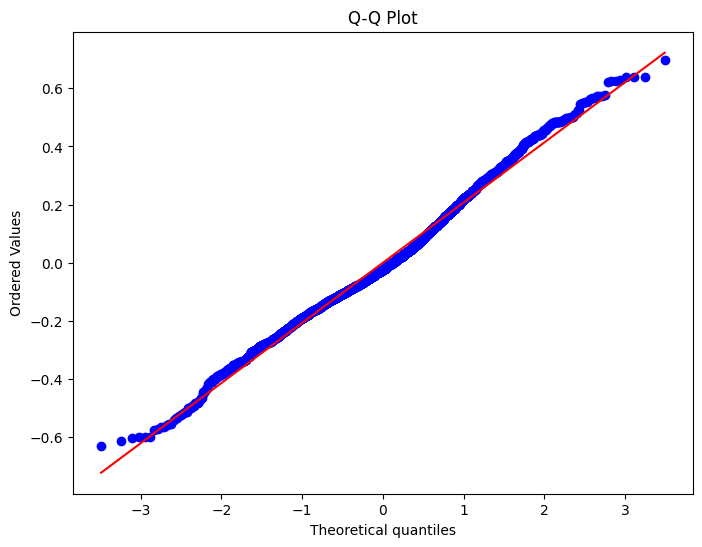

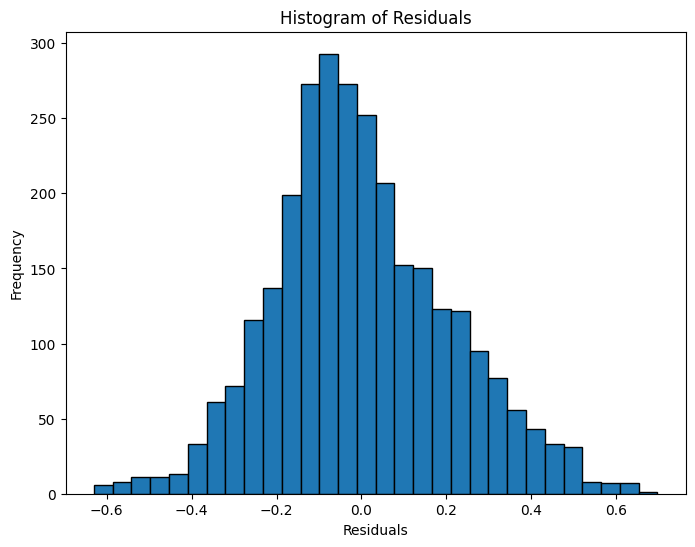

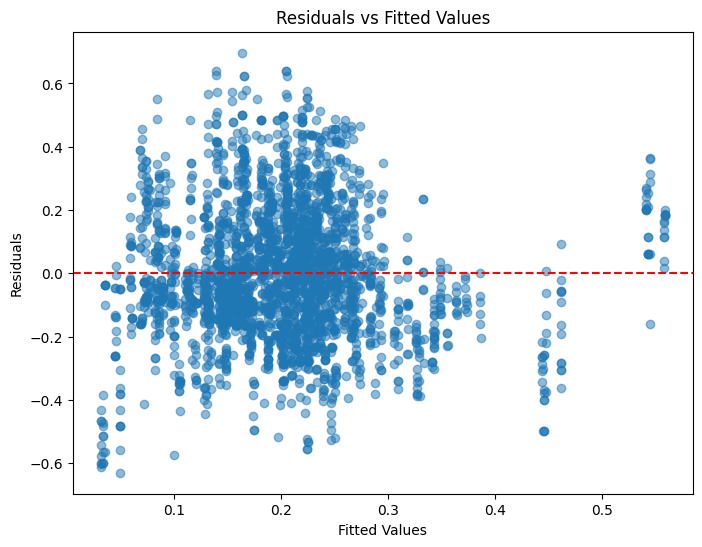

In [58]:
plot_residuals(result_d)